In [1]:
from __future__ import absolute_import, division, print_function

import keras
from keras.layers import Dense, Flatten, Dropout, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,BatchNormalization
from keras import regularizers
from keras import layers
from keras.models import Sequential,load_model
from keras import backend as K
from keras.callbacks import *
from keras.initializers import glorot_normal
from keras.optimizers import SGD, Adam
from keras.constraints import max_norm
from keras.preprocessing import image
from keras.models import Model
from keras.utils import multi_gpu_model

from keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

import numpy as np
from scipy import fftpack
from scipy import ndimage

from IPython.display import clear_output
from matplotlib import pyplot as plt

import cv2

import pickle
import os.path
import sys
import zipfile

sys.path.append('..')
from defectfinder import gridsearch as gs

Using TensorFlow backend.


In [2]:
gs.detectGPU()

----Available GPUs(if GPU is detected, the code will automatically run on GPU)----
['/job:localhost/replica:0/task:0/device:GPU:0']
----Devices imformation----
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9682875829662913125
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11272526234
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7168045846290378984
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [3]:
# unzip the dataset and load
zip_ref=zipfile.ZipFile(".././dataset/dataset_noise.zip",'r')
zip_ref.extractall(".././dataset")
zip_ref.close()

In [3]:
x_train_origin=np.load(".././dataset/dataset_noise/x_train.npy")
x_test_origin=np.load(".././dataset/dataset_noise/x_test.npy")
y_train_origin=np.load(".././dataset/dataset_noise/y_train.npy")
y_test_origin=np.load(".././dataset/dataset_noise/y_test.npy")

In [4]:
# make it center to 0, and the standarddeviation is 1
x_train=(x_train_origin-np.mean(x_train_origin))/np.std(x_train_origin)
x_test=(x_test_origin-np.mean(x_train_origin))/np.std(x_train_origin)

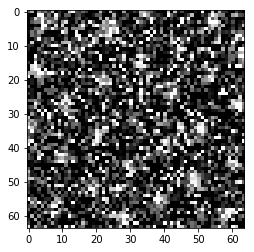

In [5]:
plt.imshow(np.reshape(x_train[752],(64,64)),cmap='gray')

## Test the model
* At first we use only a small amount of data to test the model. The accuracy of a good model is expected to be 1.00 (Though the validation accuracy maybe very low)

In [12]:
num_classes = 6

# input image dimensions
img_x, img_y = 64, 64
input_shape = (img_x, img_y, 1)

In [13]:
#At beginning only use very few training data
x_train_sample,y_train_sample=resample(x_train_origin,y_train_origin,n_samples=60,replace=False)
x_test_sample,y_test_sample=resample(x_test_origin,y_test_origin,n_samples=20,replace=False)

x_train_sample=(x_train_sample-np.mean(x_train_sample))/np.std(x_train_sample)
x_test_sample=(x_test_sample-np.mean(x_train_sample))/np.std(x_train_sample)

* May need to upgrade to the latest version of tensorflow when use "get_model()"

In [32]:
#model=gridsearch.get_model(0.01) #learning rate=0.01

In [11]:
plot = gs.PlotLearning()

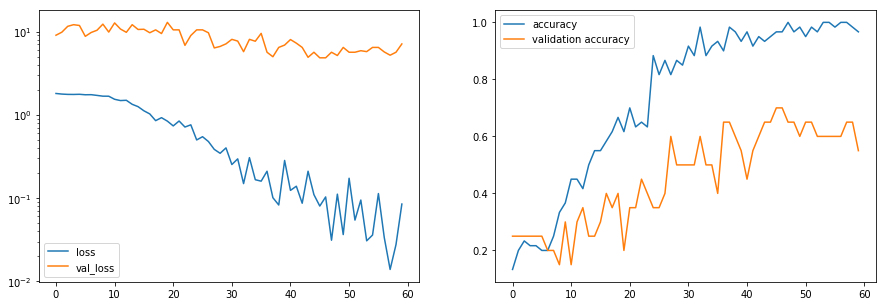

In [14]:
model4.fit(x_train_sample,y_train_sample,
         batch_size=16,
         epochs=60,
         verbose=1,
         validation_data=(x_test_sample,y_test_sample),
         callbacks=[plot])

## Grid Search
* Randomly search learning rate from 1e-5 to 1

In [21]:
np.random.seed(304)

learn_rate=(10**np.random.uniform(-5,0,15)).tolist() 
# this the list of learning rate you want to search

sgd_momentum=np.random.uniform(0,1,3).tolist()

batch_size=128
epochs=150

In [24]:
np.random.seed(523)
learn_rate_adam=(10**np.random.uniform(-5,-2,6)).tolist()

In [25]:
learn_rate_adam

[1.2630177760639675e-05,
 1.5613045997891705e-05,
 0.00016215304927075336,
 0.00469565776713492,
 0.00034058781883253536,
 0.007452871765587473]

In [28]:
search_dropout=[0.2,0.4]

In [9]:
def get_model2(learn_rate,sgd_momentum):

    '''
    get keras convolutional neural network model with given learning rate

    Arguments:learning rate

    Returns:keras model

    Raises:Error if the input is not a float.

    '''

    assert type(learn_rate)==float,"learning rate must be a float"
    assert type(sgd_momentum)==float,"momentum must be a float"
    
    model = Sequential()

    ##### add layers to CNN model: 
    #model.add(Conv2D(8,kernel_size=(7,7),use_bias=False,strides=(1,1),
    #               input_shape=(64,64,1),kernel_initializer="glorot_normal"))
    #padding = 'same'
    model.add(Conv2D(8,kernel_size=(5,5),use_bias=False,strides=(1,1),
                     input_shape=(64,64,1),kernel_initializer="glorot_normal"))
    model.add(Conv2D(16,kernel_size=(5,5),use_bias=False,strides=(1,1),
                     input_shape=(64,64,1),kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.20))
    
    model.add(Conv2D(32,(5,5),use_bias=False,kernel_initializer="glorot_normal"))
    #model.add(Conv2D(16,(3,3),use_bias=False,kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.20))
    
    model.add(Conv2D(64,(3,3),use_bias=False,kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.20))
    
    model.add(Conv2D(128,(3,3),use_bias=False,kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.20))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.20))
    model.add(Dense(6))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("softmax"))
    
    #sgd = SGD(lr=learn_rate,momentum=sgd_momentum)
    adam= Adam(lr=learn_rate)
    model.compile(loss = 'categorical_crossentropy',optimizer = adam, metrics=['accuracy'])
    return model


In [33]:
def get_model3(learn_rate,dropoutP):

    '''
    get keras convolutional neural network model with given learning rate

    Arguments:learning rate

    Returns:keras model

    Raises:Error if the input is not a float.

    '''

    assert type(learn_rate)==float,"learning rate must be a float"
    assert dropoutP<1.,"drop out rate must less than 1"
    
    model = Sequential()

    ##### add layers to CNN model: 
    #model.add(Conv2D(8,kernel_size=(7,7),use_bias=False,strides=(1,1),
    #               input_shape=(64,64,1),kernel_initializer="glorot_normal"))
    #padding = 'same'
    model.add(Conv2D(8,kernel_size=(5,5),use_bias=False,strides=(1,1),
                     input_shape=(64,64,1),kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(Conv2D(16,kernel_size=(5,5),use_bias=False,strides=(1,1),
                     kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(dropoutP))
    
    model.add(Conv2D(32,(5,5),use_bias=False,kernel_initializer="glorot_normal"))
    #model.add(Conv2D(16,(3,3),use_bias=False,kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(dropoutP))
    
    model.add(Conv2D(64,(3,3),use_bias=False,kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(dropoutP))
    
    model.add(Conv2D(128,(3,3),use_bias=False,kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(dropoutP))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(dropoutP))
    model.add(Dense(6))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("softmax"))
    
    #sgd = SGD(lr=learn_rate,momentum=sgd_momentum)
    adam= Adam(lr=learn_rate)
    model.compile(loss = 'categorical_crossentropy',optimizer = adam, metrics=['accuracy'])
    return model



In [34]:
def get_model4(learn_rate,dropoutP):

    '''
    get keras convolutional neural network model with given learning rate

    Arguments:learning rate

    Returns:keras model

    Raises:Error if the input is not a float.

    '''

    assert type(learn_rate)==float,"learning rate must be a float"
    assert dropoutP<1.,"drop out rate must less than 1"
    
    model = Sequential()

    ##### add layers to CNN model: 
    #model.add(Conv2D(8,kernel_size=(7,7),use_bias=False,strides=(1,1),
    #               input_shape=(64,64,1),kernel_initializer="glorot_normal"))
    #padding = 'same'
    model.add(Conv2D(8,kernel_size=(5,5),use_bias=False,strides=(1,1),
                     input_shape=(64,64,1),kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(Conv2D(16,kernel_size=(5,5),use_bias=False,strides=(1,1),
                     kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(dropoutP))
    
    model.add(Conv2D(32,(3,3),use_bias=False,kernel_initializer="glorot_normal"))
    #model.add(Conv2D(16,(3,3),use_bias=False,kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(Conv2D(32,(3,3),use_bias=False,kernel_initializer="glorot_normal"))
    #model.add(Conv2D(16,(3,3),use_bias=False,kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(dropoutP))
    
    model.add(Conv2D(64,(3,3),use_bias=False,kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(dropoutP))
    
    model.add(Conv2D(128,(3,3),use_bias=False,kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(dropoutP))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(dropoutP))
    model.add(Dense(6))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("softmax"))
    
    #sgd = SGD(lr=learn_rate,momentum=sgd_momentum)
    adam= Adam(lr=learn_rate)
    model.compile(loss = 'categorical_crossentropy',optimizer = adam, metrics=['accuracy'])
    return model

In [10]:
model3=get_model3(0.001,0.9)

In [15]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

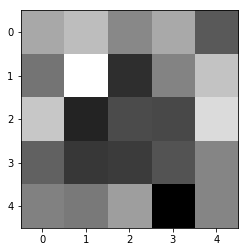

In [16]:
top_layer = model.layers[0]
plt.imshow(top_layer.get_weights()[0][:,:,:,0].squeeze(),cmap='gray')

In [35]:
def gridsearch(x_train,y_train_origin,learn_rate,sgd_momentum,batch_size,epochs,filename):

    '''
    given the training dataset, it will be randomly split into training and validation set
    and the keras model will be trained with given learn_rate, batch size and epochs

    Arguments:
    x_train: x training dataset, need to be centered

    y_train_origin: y training dataset, needless to be centered

    learn_rate: a list of learning rate

    batchsize: a int

    epochs: a int

    Returns:
    fitresult: a list, each element is a keras history object
    models_grid: a list, each element is a trained model

    every model, training history model_weights will be saved in a folder named learnrate

    Raises:
    error if the shape of x or y is wrong

    ''' 
    assert np.shape(x_train)[1:4]==(64, 64, 1),"the expected shape of x_train is (channels,img_x,img_y,1)"
    
    assert np.shape(y_train_origin)[1]==6,"the expected shape of y_train is (channels,6)"

    #create a new directory to save all the training history and model_weights
    version=1
    while os.path.exists('../HyperparametersTuning/'+filename+str(version)):
        version=version+1
    os.makedirs('../HyperparametersTuning/'+filename+str(version))
    
    search_grid=[(learn_rate[i],sgd_momentum[j]) 
                 for i in range(len(learn_rate)) for j in range(len(sgd_momentum))]

    fitresult=[] #list save history of each keras model
    models_grid=[get_model3(learn_rate[0],sgd_momentum[0])]*len(search_grid) #list save each keras model
    
    for i in range(len(search_grid)):
        #randomly split the training data into training set and validation set
        x_tra,x_val,y_tra,y_val=train_test_split(x_train,y_train_origin,test_size=0.33)
        models_grid[i]=get_model3(search_grid[i][0],search_grid[i][1])
        fitresult.append(models_grid[i].fit(x_tra,y_tra,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            verbose=1,
                                            validation_data=(x_val,y_val),shuffle=True))  
    
    with open('../HyperparametersTuning/'+filename+str(version)+"/search_grid.txt","wb") as fp:
        pickle.dump(search_grid,fp)
    
    for i in range(len(fitresult)):
        #save history of each model
        with open('../HyperparametersTuning/'+filename+str(version)+"/fitresult"+str(i)+".txt","wb") as fp:
            pickle.dump(fitresult[i].history,fp)
            
        #save each model and weights:
        models_grid[i].save('../HyperparametersTuning/'+filename+str(version)+'/model'+str(i)+'.h5')
        models_grid[i].save_weights('../HyperparametersTuning/'+filename+str(version)+'/model_weight'+str(i)+'.h5')
        
    return fitresult,models_grid,search_grid


In [45]:
# models is a list of models with learning rate from the search list
# result is a list of training history

result,models,search_grid=gridsearch(x_train,y_train_origin,learn_rate_adam,search_dropout,batch_size,100,
                        "learn_rate_dropoutsearch_AdamM3")

Train on 26895 samples, validate on 13247 samples
Epoch 1/100
26895/26895 [==============================] - 7s 275us/step - loss: 1.7936 - acc: 0.1788 - val_loss: 1.7812 - val_acc: 0.1792
Epoch 2/100
26895/26895 [==============================] - 6s 224us/step - loss: 1.7804 - acc: 0.1835 - val_loss: 1.7770 - val_acc: 0.1840
Epoch 3/100
26895/26895 [==============================] - 6s 223us/step - loss: 1.7715 - acc: 0.2016 - val_loss: 1.7678 - val_acc: 0.2278
Epoch 4/100
26895/26895 [==============================] - 6s 224us/step - loss: 1.7526 - acc: 0.2412 - val_loss: 1.7385 - val_acc: 0.3771
Epoch 5/100
26895/26895 [==============================] - 6s 225us/step - loss: 1.6925 - acc: 0.3085 - val_loss: 1.6336 - val_acc: 0.4398
Epoch 6/100
26895/26895 [==============================] - 6s 225us/step - loss: 1.5219 - acc: 0.4008 - val_loss: 1.3801 - val_acc: 0.5059
Epoch 7/100
26895/26895 [==============================] - 6s 223us/step - loss: 1.3039 - acc: 0.4516 - val_loss: 1.

26895/26895 [==============================] - 6s 225us/step - loss: 0.4702 - acc: 0.7919 - val_loss: 0.3783 - val_acc: 0.8417
Epoch 60/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.4687 - acc: 0.7944 - val_loss: 0.3767 - val_acc: 0.8412
Epoch 61/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.4637 - acc: 0.7984 - val_loss: 0.3741 - val_acc: 0.8439
Epoch 62/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.4647 - acc: 0.7954 - val_loss: 0.3725 - val_acc: 0.8450
Epoch 63/100
26895/26895 [==============================] - 6s 223us/step - loss: 0.4638 - acc: 0.7969 - val_loss: 0.3738 - val_acc: 0.8433
Epoch 64/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.4566 - acc: 0.7972 - val_loss: 0.3702 - val_acc: 0.8449
Epoch 65/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.4626 - acc: 0.7952 - val_loss: 0.3687 - val_acc: 0.8471
Epoch 66/100
26895/26895 [=======

26895/26895 [==============================] - 6s 221us/step - loss: 1.2351 - acc: 0.4492 - val_loss: 1.2202 - val_acc: 0.5484
Epoch 18/100
26895/26895 [==============================] - 6s 222us/step - loss: 1.2175 - acc: 0.4525 - val_loss: 1.1938 - val_acc: 0.5536
Epoch 19/100
26895/26895 [==============================] - 6s 224us/step - loss: 1.1963 - acc: 0.4641 - val_loss: 1.1729 - val_acc: 0.5580
Epoch 20/100
26895/26895 [==============================] - 6s 225us/step - loss: 1.1778 - acc: 0.4737 - val_loss: 1.1490 - val_acc: 0.5631
Epoch 21/100
26895/26895 [==============================] - 6s 221us/step - loss: 1.1647 - acc: 0.4795 - val_loss: 1.1350 - val_acc: 0.5693
Epoch 22/100
26895/26895 [==============================] - 6s 218us/step - loss: 1.1471 - acc: 0.4886 - val_loss: 1.1198 - val_acc: 0.5690
Epoch 23/100
26895/26895 [==============================] - 6s 223us/step - loss: 1.1379 - acc: 0.4931 - val_loss: 1.1075 - val_acc: 0.5765
Epoch 24/100
26895/26895 [=======

26895/26895 [==============================] - 6s 223us/step - loss: 0.6818 - acc: 0.6867 - val_loss: 0.6027 - val_acc: 0.7647
Epoch 76/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.6763 - acc: 0.6853 - val_loss: 0.5987 - val_acc: 0.7667
Epoch 77/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.6690 - acc: 0.6906 - val_loss: 0.5950 - val_acc: 0.7686
Epoch 78/100
26895/26895 [==============================] - 6s 223us/step - loss: 0.6696 - acc: 0.6911 - val_loss: 0.5983 - val_acc: 0.7603
Epoch 79/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.6664 - acc: 0.6892 - val_loss: 0.5981 - val_acc: 0.7623
Epoch 80/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.6598 - acc: 0.6913 - val_loss: 0.5842 - val_acc: 0.7690
Epoch 81/100
26895/26895 [==============================] - 6s 222us/step - loss: 0.6594 - acc: 0.6927 - val_loss: 0.5817 - val_acc: 0.7679
Epoch 82/100
26895/26895 [=======

26895/26895 [==============================] - 6s 225us/step - loss: 0.5396 - acc: 0.7553 - val_loss: 0.4417 - val_acc: 0.8194
Epoch 34/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.5325 - acc: 0.7607 - val_loss: 0.4396 - val_acc: 0.8203
Epoch 35/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.5246 - acc: 0.7652 - val_loss: 0.4451 - val_acc: 0.8133
Epoch 36/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.5202 - acc: 0.7643 - val_loss: 0.4280 - val_acc: 0.8234
Epoch 37/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.5191 - acc: 0.7657 - val_loss: 0.4233 - val_acc: 0.8272
Epoch 38/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.5112 - acc: 0.7710 - val_loss: 0.4196 - val_acc: 0.8271
Epoch 39/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.5095 - acc: 0.7700 - val_loss: 0.4194 - val_acc: 0.8244
Epoch 40/100
26895/26895 [=======

26895/26895 [==============================] - 6s 226us/step - loss: 0.3738 - acc: 0.8402 - val_loss: 0.3059 - val_acc: 0.8746
Epoch 92/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.3697 - acc: 0.8405 - val_loss: 0.3037 - val_acc: 0.8748
Epoch 93/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.3680 - acc: 0.8409 - val_loss: 0.3002 - val_acc: 0.8779
Epoch 94/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.3660 - acc: 0.8409 - val_loss: 0.3011 - val_acc: 0.8787
Epoch 95/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.3663 - acc: 0.8430 - val_loss: 0.2998 - val_acc: 0.8771
Epoch 96/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.3655 - acc: 0.8441 - val_loss: 0.2982 - val_acc: 0.8791
Epoch 97/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.3637 - acc: 0.8421 - val_loss: 0.2976 - val_acc: 0.8795
Epoch 98/100
26895/26895 [=======

26895/26895 [==============================] - 6s 224us/step - loss: 0.7024 - acc: 0.6749 - val_loss: 0.6199 - val_acc: 0.7330
Epoch 50/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.6996 - acc: 0.6718 - val_loss: 0.6233 - val_acc: 0.7273
Epoch 51/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.6930 - acc: 0.6771 - val_loss: 0.6212 - val_acc: 0.7298
Epoch 52/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.6869 - acc: 0.6804 - val_loss: 0.6148 - val_acc: 0.7325
Epoch 53/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.6821 - acc: 0.6838 - val_loss: 0.6026 - val_acc: 0.7389
Epoch 54/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.6797 - acc: 0.6851 - val_loss: 0.5931 - val_acc: 0.7439
Epoch 55/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.6742 - acc: 0.6853 - val_loss: 0.6026 - val_acc: 0.7360
Epoch 56/100
26895/26895 [=======

26895/26895 [==============================] - 6s 224us/step - loss: 0.4160 - acc: 0.8178 - val_loss: 0.3365 - val_acc: 0.8628
Epoch 8/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.3982 - acc: 0.8276 - val_loss: 0.3111 - val_acc: 0.8736
Epoch 9/100
26895/26895 [==============================] - 6s 222us/step - loss: 0.3815 - acc: 0.8352 - val_loss: 0.3058 - val_acc: 0.8748
Epoch 10/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.3672 - acc: 0.8421 - val_loss: 0.2855 - val_acc: 0.8844
Epoch 11/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.3532 - acc: 0.8499 - val_loss: 0.2761 - val_acc: 0.8841
Epoch 12/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.3388 - acc: 0.8557 - val_loss: 0.2716 - val_acc: 0.8917
Epoch 13/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.3259 - acc: 0.8618 - val_loss: 0.2563 - val_acc: 0.8939
Epoch 14/100
26895/26895 [=========

26895/26895 [==============================] - 6s 222us/step - loss: 0.1310 - acc: 0.9488 - val_loss: 0.1286 - val_acc: 0.9503
Epoch 66/100
26895/26895 [==============================] - 6s 223us/step - loss: 0.1325 - acc: 0.9498 - val_loss: 0.1211 - val_acc: 0.9541
Epoch 67/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.1328 - acc: 0.9482 - val_loss: 0.1232 - val_acc: 0.9535
Epoch 68/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.1308 - acc: 0.9489 - val_loss: 0.1218 - val_acc: 0.9545
Epoch 69/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.1319 - acc: 0.9503 - val_loss: 0.1269 - val_acc: 0.9527
Epoch 70/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.1241 - acc: 0.9524 - val_loss: 0.1272 - val_acc: 0.9506
Epoch 71/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.1255 - acc: 0.9513 - val_loss: 0.1268 - val_acc: 0.9515
Epoch 72/100
26895/26895 [=======

26895/26895 [==============================] - 6s 225us/step - loss: 0.4417 - acc: 0.7962 - val_loss: 0.3767 - val_acc: 0.8411
Epoch 24/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.4394 - acc: 0.7978 - val_loss: 0.3690 - val_acc: 0.8504
Epoch 25/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.4245 - acc: 0.8061 - val_loss: 0.3683 - val_acc: 0.8546
Epoch 26/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.4247 - acc: 0.8069 - val_loss: 0.3554 - val_acc: 0.8590
Epoch 27/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.4162 - acc: 0.8097 - val_loss: 0.3554 - val_acc: 0.8593
Epoch 28/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.4166 - acc: 0.8121 - val_loss: 0.3457 - val_acc: 0.8612
Epoch 29/100
26895/26895 [==============================] - 6s 219us/step - loss: 0.4119 - acc: 0.8158 - val_loss: 0.3433 - val_acc: 0.8628
Epoch 30/100
26895/26895 [=======

26895/26895 [==============================] - 6s 225us/step - loss: 0.2729 - acc: 0.8887 - val_loss: 0.2116 - val_acc: 0.9219
Epoch 82/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.2787 - acc: 0.8876 - val_loss: 0.2139 - val_acc: 0.9190
Epoch 83/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.2719 - acc: 0.8885 - val_loss: 0.2153 - val_acc: 0.9201
Epoch 84/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.2744 - acc: 0.8865 - val_loss: 0.2077 - val_acc: 0.9229
Epoch 85/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.2689 - acc: 0.8910 - val_loss: 0.2068 - val_acc: 0.9219
Epoch 86/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.2728 - acc: 0.8903 - val_loss: 0.2080 - val_acc: 0.9225
Epoch 87/100
26895/26895 [==============================] - 6s 220us/step - loss: 0.2685 - acc: 0.8908 - val_loss: 0.2055 - val_acc: 0.9244
Epoch 88/100
26895/26895 [=======

26895/26895 [==============================] - 6s 226us/step - loss: 0.3066 - acc: 0.8743 - val_loss: 0.2389 - val_acc: 0.9077
Epoch 40/100
26895/26895 [==============================] - 6s 229us/step - loss: 0.3076 - acc: 0.8758 - val_loss: 0.2406 - val_acc: 0.9079
Epoch 41/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.3129 - acc: 0.8741 - val_loss: 0.2499 - val_acc: 0.9099
Epoch 42/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.3124 - acc: 0.8721 - val_loss: 0.2410 - val_acc: 0.9078
Epoch 43/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.3079 - acc: 0.8733 - val_loss: 0.2526 - val_acc: 0.9027
Epoch 44/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.3171 - acc: 0.8732 - val_loss: 0.2576 - val_acc: 0.8998
Epoch 45/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.3152 - acc: 0.8725 - val_loss: 0.2450 - val_acc: 0.9051
Epoch 46/100
26895/26895 [=======

26895/26895 [==============================] - 6s 225us/step - loss: 0.3042 - acc: 0.8820 - val_loss: 0.2508 - val_acc: 0.9084
Epoch 98/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.2999 - acc: 0.8813 - val_loss: 0.2765 - val_acc: 0.9001
Epoch 99/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.3008 - acc: 0.8822 - val_loss: 0.2310 - val_acc: 0.9130
Epoch 100/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.2859 - acc: 0.8861 - val_loss: 0.2477 - val_acc: 0.9050
Train on 26895 samples, validate on 13247 samples
Epoch 1/100
26895/26895 [==============================] - 8s 295us/step - loss: 1.0873 - acc: 0.5001 - val_loss: 0.8215 - val_acc: 0.6577
Epoch 2/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.7468 - acc: 0.6471 - val_loss: 0.6499 - val_acc: 0.7076
Epoch 3/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.7065 - acc: 0.6760 - val_loss: 0.9281 - v

26895/26895 [==============================] - 6s 226us/step - loss: 0.5950 - acc: 0.7403 - val_loss: 0.6064 - val_acc: 0.7547
Epoch 56/100
26895/26895 [==============================] - 6s 229us/step - loss: 0.5984 - acc: 0.7384 - val_loss: 0.5803 - val_acc: 0.7693
Epoch 57/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.5938 - acc: 0.7420 - val_loss: 0.6224 - val_acc: 0.7596
Epoch 58/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.5883 - acc: 0.7444 - val_loss: 0.5588 - val_acc: 0.7704
Epoch 59/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.5882 - acc: 0.7427 - val_loss: 0.5672 - val_acc: 0.7758
Epoch 60/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.5926 - acc: 0.7467 - val_loss: 0.5664 - val_acc: 0.7818
Epoch 61/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.5885 - acc: 0.7464 - val_loss: 0.5999 - val_acc: 0.7673
Epoch 62/100
26895/26895 [=======

26895/26895 [==============================] - 6s 227us/step - loss: 0.2547 - acc: 0.8945 - val_loss: 0.1878 - val_acc: 0.9269
Epoch 14/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.2485 - acc: 0.8983 - val_loss: 0.1952 - val_acc: 0.9235
Epoch 15/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.2396 - acc: 0.9046 - val_loss: 0.1769 - val_acc: 0.9310
Epoch 16/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.2305 - acc: 0.9046 - val_loss: 0.1742 - val_acc: 0.9325
Epoch 17/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.2237 - acc: 0.9097 - val_loss: 0.1743 - val_acc: 0.9340
Epoch 18/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.2121 - acc: 0.9137 - val_loss: 0.1671 - val_acc: 0.9321
Epoch 19/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.2113 - acc: 0.9150 - val_loss: 0.1565 - val_acc: 0.9405
Epoch 20/100
26895/26895 [=======

26895/26895 [==============================] - 6s 226us/step - loss: 0.0947 - acc: 0.9641 - val_loss: 0.1089 - val_acc: 0.9600
Epoch 72/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.0910 - acc: 0.9650 - val_loss: 0.1090 - val_acc: 0.9605
Epoch 73/100
26895/26895 [==============================] - 6s 223us/step - loss: 0.0874 - acc: 0.9669 - val_loss: 0.1055 - val_acc: 0.9612
Epoch 74/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.0914 - acc: 0.9654 - val_loss: 0.1036 - val_acc: 0.9616
Epoch 75/100
26895/26895 [==============================] - 6s 223us/step - loss: 0.0871 - acc: 0.9668 - val_loss: 0.1100 - val_acc: 0.9593
Epoch 76/100
26895/26895 [==============================] - 6s 223us/step - loss: 0.0880 - acc: 0.9667 - val_loss: 0.1075 - val_acc: 0.9601
Epoch 77/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.0857 - acc: 0.9694 - val_loss: 0.1059 - val_acc: 0.9609
Epoch 78/100
26895/26895 [=======

26895/26895 [==============================] - 6s 227us/step - loss: 0.3122 - acc: 0.8695 - val_loss: 0.2349 - val_acc: 0.9077
Epoch 30/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.3105 - acc: 0.8705 - val_loss: 0.2358 - val_acc: 0.9071
Epoch 31/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.3070 - acc: 0.8719 - val_loss: 0.2425 - val_acc: 0.9041
Epoch 32/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.3035 - acc: 0.8769 - val_loss: 0.2302 - val_acc: 0.9078
Epoch 33/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.3060 - acc: 0.8734 - val_loss: 0.2277 - val_acc: 0.9112
Epoch 34/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.2963 - acc: 0.8773 - val_loss: 0.2245 - val_acc: 0.9126
Epoch 35/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.2920 - acc: 0.8784 - val_loss: 0.2259 - val_acc: 0.9120
Epoch 36/100
26895/26895 [=======

26895/26895 [==============================] - 6s 225us/step - loss: 0.2197 - acc: 0.9149 - val_loss: 0.1731 - val_acc: 0.9339
Epoch 88/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.2190 - acc: 0.9129 - val_loss: 0.1748 - val_acc: 0.9309
Epoch 89/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.2193 - acc: 0.9139 - val_loss: 0.1868 - val_acc: 0.9269
Epoch 90/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.2184 - acc: 0.9134 - val_loss: 0.1727 - val_acc: 0.9337
Epoch 91/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.2187 - acc: 0.9131 - val_loss: 0.1738 - val_acc: 0.9343
Epoch 92/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.2177 - acc: 0.9142 - val_loss: 0.1764 - val_acc: 0.9309
Epoch 93/100
26895/26895 [==============================] - 6s 224us/step - loss: 0.2120 - acc: 0.9149 - val_loss: 0.1784 - val_acc: 0.9287
Epoch 94/100
26895/26895 [=======

26895/26895 [==============================] - 6s 227us/step - loss: 0.4725 - acc: 0.8074 - val_loss: 0.3666 - val_acc: 0.8639
Epoch 46/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.4794 - acc: 0.8063 - val_loss: 0.3839 - val_acc: 0.8474
Epoch 47/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.4751 - acc: 0.8044 - val_loss: 0.4044 - val_acc: 0.8488
Epoch 48/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.4753 - acc: 0.8058 - val_loss: 0.3525 - val_acc: 0.8608
Epoch 49/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.4955 - acc: 0.7991 - val_loss: 0.3845 - val_acc: 0.8513
Epoch 50/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.4891 - acc: 0.8026 - val_loss: 0.3833 - val_acc: 0.8545
Epoch 51/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.4879 - acc: 0.8000 - val_loss: 0.3500 - val_acc: 0.8680
Epoch 52/100
26895/26895 [=======

26895/26895 [==============================] - 6s 227us/step - loss: 1.7802 - acc: 0.1731 - val_loss: 1.7841 - val_acc: 0.1761
Epoch 4/100
26895/26895 [==============================] - 6s 227us/step - loss: 1.7802 - acc: 0.1762 - val_loss: 1.7845 - val_acc: 0.1763
Epoch 5/100
26895/26895 [==============================] - 6s 227us/step - loss: 1.7800 - acc: 0.1777 - val_loss: 1.7831 - val_acc: 0.1822
Epoch 6/100
26895/26895 [==============================] - 6s 226us/step - loss: 1.7801 - acc: 0.1757 - val_loss: 1.7829 - val_acc: 0.1763
Epoch 7/100
26895/26895 [==============================] - 6s 225us/step - loss: 1.7802 - acc: 0.1741 - val_loss: 1.7832 - val_acc: 0.1761
Epoch 8/100
26895/26895 [==============================] - 6s 226us/step - loss: 1.7800 - acc: 0.1766 - val_loss: 1.7832 - val_acc: 0.1822
Epoch 9/100
26895/26895 [==============================] - 6s 223us/step - loss: 1.7801 - acc: 0.1752 - val_loss: 1.7830 - val_acc: 0.1822
Epoch 10/100
26895/26895 [=============

26895/26895 [==============================] - 6s 224us/step - loss: 1.7801 - acc: 0.1776 - val_loss: 1.7838 - val_acc: 0.1761
Epoch 62/100
26895/26895 [==============================] - 6s 226us/step - loss: 1.7801 - acc: 0.1780 - val_loss: 1.7835 - val_acc: 0.1761
Epoch 63/100
26895/26895 [==============================] - 6s 227us/step - loss: 1.7801 - acc: 0.1759 - val_loss: 1.7829 - val_acc: 0.1763
Epoch 64/100
26895/26895 [==============================] - 6s 226us/step - loss: 1.7802 - acc: 0.1756 - val_loss: 1.7837 - val_acc: 0.1763
Epoch 65/100
26895/26895 [==============================] - 6s 226us/step - loss: 1.7801 - acc: 0.1801 - val_loss: 1.7827 - val_acc: 0.1822
Epoch 66/100
26895/26895 [==============================] - 6s 226us/step - loss: 1.7801 - acc: 0.1788 - val_loss: 1.7828 - val_acc: 0.1761
Epoch 67/100
26895/26895 [==============================] - 6s 225us/step - loss: 1.7802 - acc: 0.1777 - val_loss: 1.7830 - val_acc: 0.1763
Epoch 68/100
26895/26895 [=======

In [52]:
# load previous search grid and previous results from the same path
path="../HyperparametersTuning/learn_rate_dropoutsearch_AdamM31"

with open(path+"/search_grid.txt","rb") as fp:
    search_grid=pickle.load(fp)
    
load_res=gs.load_results(search_grid,path)

In [47]:
def PlotLossAcc(load_res,search_grid):
    for j in range(len(load_res)):
        history=load_res[j]

        fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5),sharex=True)
        ax1.plot(history['acc'])
        ax1.plot(history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        ax1.legend(['train', 'test'], loc='upper left')

        ax2.plot(history['loss'])
        ax2.plot(history['val_loss'])
        plt.title('(LearningRate,dropout) = '+str(search_grid[j]))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        ax2.legend(['train', 'test'], loc='upper left')
        plt.show()

    return

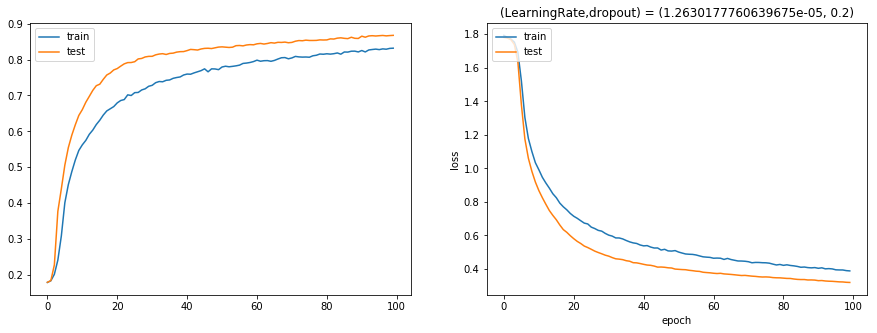

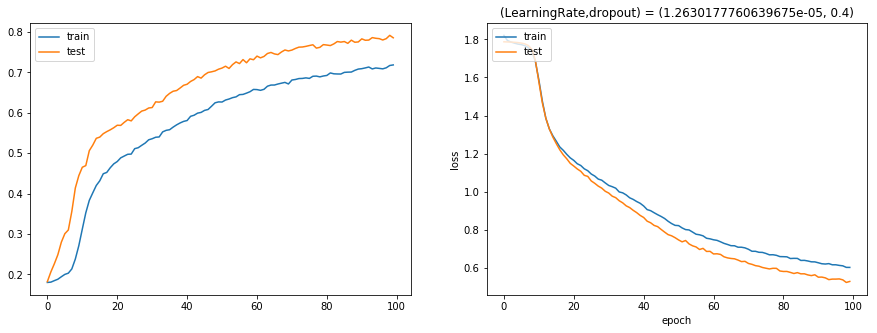

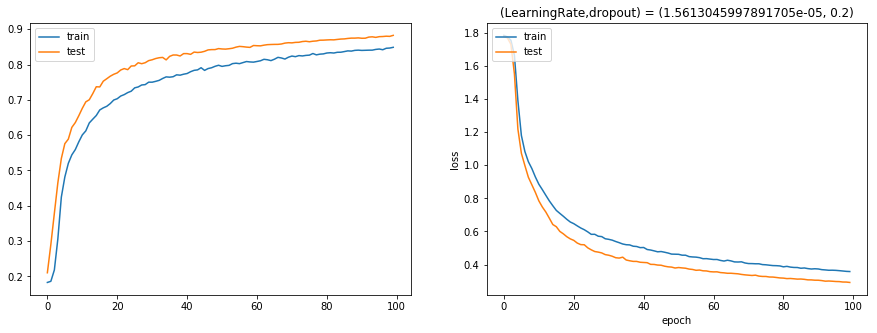

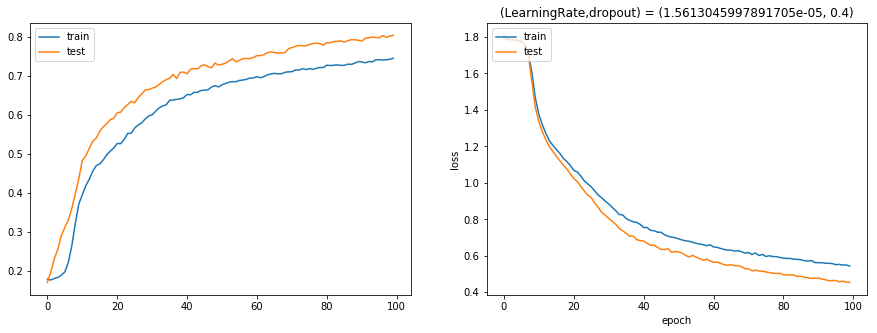

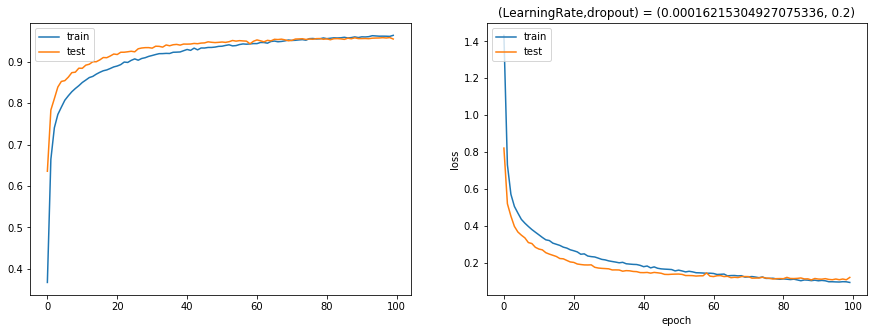

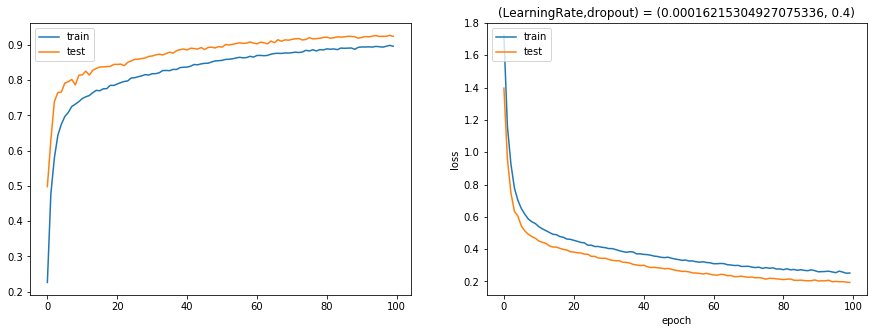

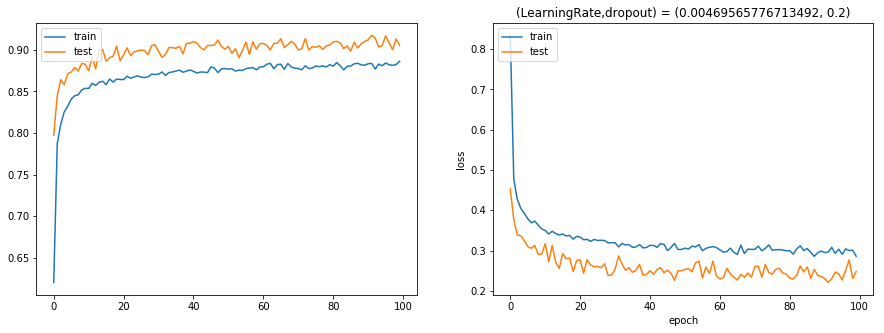

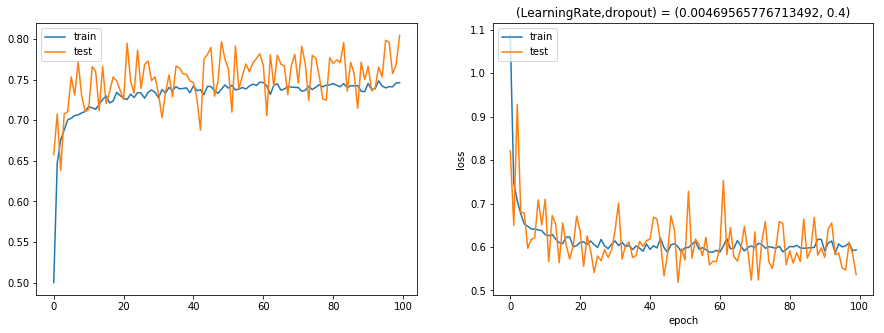

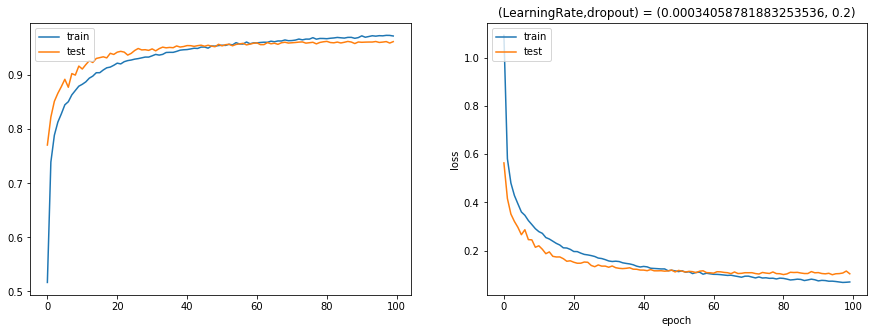

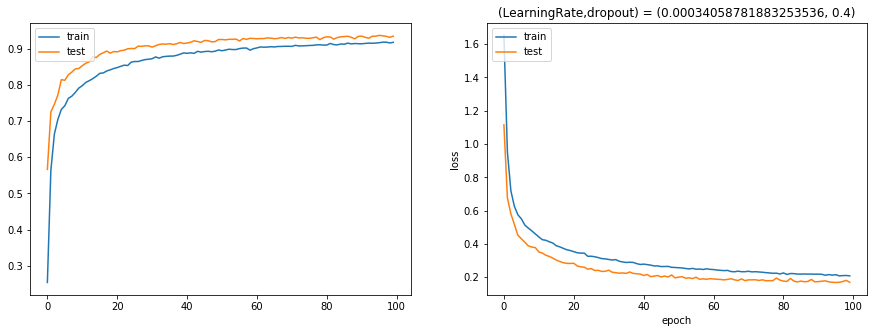

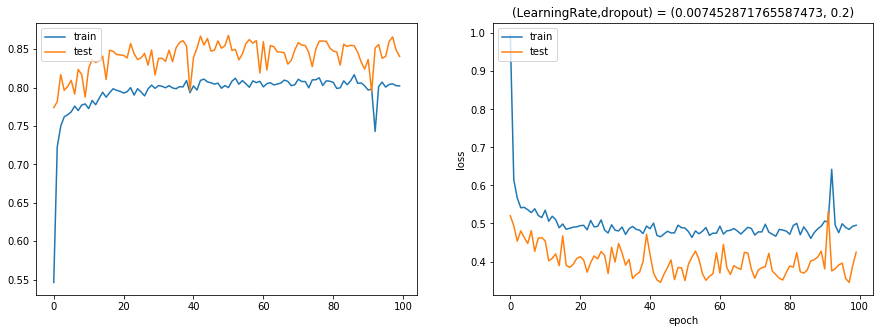

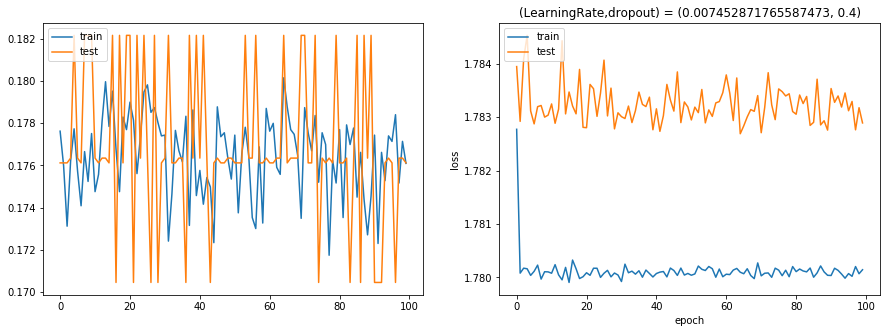

In [48]:
PlotLossAcc(load_res,search_grid)

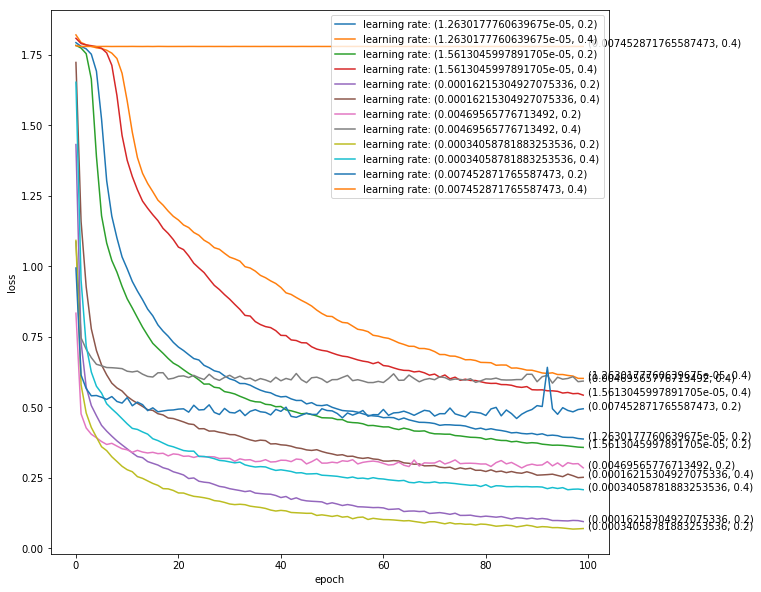

In [50]:
#plot the loss for each model
plt.figure(figsize=(10,10))

for j in range(len(load_res)):
    #if(learn_rate[j]>0.0001 and learn_rate[j]<0.02):
    plt.plot(load_res[j]['loss'],label="learning rate: "+str(search_grid[j]))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.text(100,load_res[j]['loss'][99],str(search_grid[j]))
    
plt.legend()

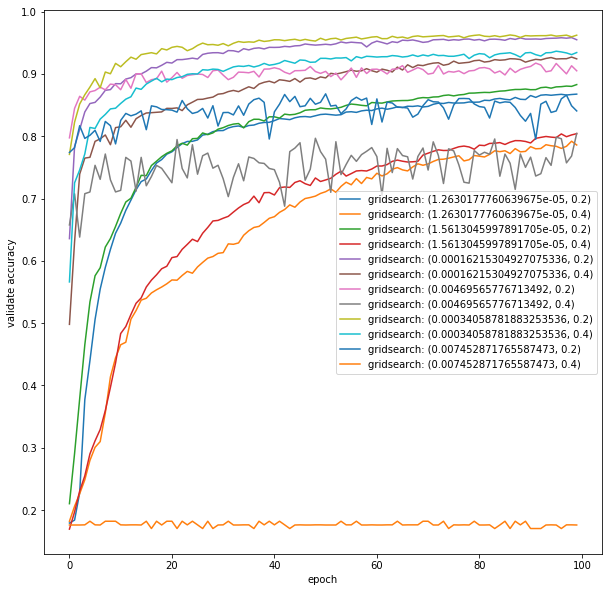

In [51]:
#plot validation accuracy for each model

plt.figure(figsize=(10,10))

for j in range(len(load_res)):
    #if(learn_rate[j]>0.001 and learn_rate[j]<0.04):
    plt.plot(load_res[j]['val_acc'],label="gridsearch: "+str(search_grid[j]))
    plt.xlabel("epoch")
    plt.ylabel("validate accuracy")
    
plt.legend()

In [53]:
search_grid

[(1.2630177760639675e-05, 0.2),
 (1.2630177760639675e-05, 0.4),
 (1.5613045997891705e-05, 0.2),
 (1.5613045997891705e-05, 0.4),
 (0.00016215304927075336, 0.2),
 (0.00016215304927075336, 0.4),
 (0.00469565776713492, 0.2),
 (0.00469565776713492, 0.4),
 (0.00034058781883253536, 0.2),
 (0.00034058781883253536, 0.4),
 (0.007452871765587473, 0.2),
 (0.007452871765587473, 0.4)]

In [55]:
#get the test accuracy of a selected model
select_model=load_model("../HyperparametersTuning/learn_rate_dropoutsearch_AdamM31/model8.h5")

scores=select_model.evaluate(x_test,y_test_origin,verbose=1)

print("%s: %.2f%%" % (select_model.metrics_names[1], scores[1]*100))

10036/10036 [==============================] - 2s 211us/step
acc: 95.68%


## Narrow the range and Search Learning rate again

In [65]:
learn_rate_narrow=[0.0003,0.0007,0.001]

In [66]:
result,models,search_grid_n=gridsearch(x_train,y_train_origin,learn_rate_narrow,[0.2],batch_size,100,
                        "learn_rate_narrow_AdamM3")

Train on 26895 samples, validate on 13247 samples
Epoch 1/100
26895/26895 [==============================] - 8s 314us/step - loss: 1.0971 - acc: 0.5121 - val_loss: 0.5641 - val_acc: 0.7544
Epoch 2/100
26895/26895 [==============================] - 6s 229us/step - loss: 0.5637 - acc: 0.7398 - val_loss: 0.4347 - val_acc: 0.8158
Epoch 3/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.4821 - acc: 0.7827 - val_loss: 0.3802 - val_acc: 0.8421
Epoch 4/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.4304 - acc: 0.8132 - val_loss: 0.3500 - val_acc: 0.8536
Epoch 5/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.4004 - acc: 0.8270 - val_loss: 0.3151 - val_acc: 0.8711
Epoch 6/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.3697 - acc: 0.8426 - val_loss: 0.2992 - val_acc: 0.8772
Epoch 7/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.3474 - acc: 0.8524 - val_loss: 0.

26895/26895 [==============================] - 6s 227us/step - loss: 0.1069 - acc: 0.9582 - val_loss: 0.1216 - val_acc: 0.9570
Epoch 60/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.1030 - acc: 0.9601 - val_loss: 0.1165 - val_acc: 0.9589
Epoch 61/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.1019 - acc: 0.9600 - val_loss: 0.1176 - val_acc: 0.9588
Epoch 62/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.1007 - acc: 0.9625 - val_loss: 0.1203 - val_acc: 0.9577
Epoch 63/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.1016 - acc: 0.9612 - val_loss: 0.1269 - val_acc: 0.9561
Epoch 64/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.0977 - acc: 0.9636 - val_loss: 0.1163 - val_acc: 0.9589
Epoch 65/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.0947 - acc: 0.9635 - val_loss: 0.1209 - val_acc: 0.9580
Epoch 66/100
26895/26895 [=======

26895/26895 [==============================] - 6s 229us/step - loss: 0.1909 - acc: 0.9235 - val_loss: 0.1574 - val_acc: 0.9373
Epoch 18/100
26895/26895 [==============================] - 6s 230us/step - loss: 0.1844 - acc: 0.9246 - val_loss: 0.1496 - val_acc: 0.9424
Epoch 19/100
26895/26895 [==============================] - 6s 230us/step - loss: 0.1802 - acc: 0.9280 - val_loss: 0.1574 - val_acc: 0.9398
Epoch 20/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.1786 - acc: 0.9304 - val_loss: 0.1445 - val_acc: 0.9446
Epoch 21/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.1676 - acc: 0.9330 - val_loss: 0.1430 - val_acc: 0.9450
Epoch 22/100
26895/26895 [==============================] - 6s 229us/step - loss: 0.1678 - acc: 0.9333 - val_loss: 0.1353 - val_acc: 0.9481
Epoch 23/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.1635 - acc: 0.9356 - val_loss: 0.1342 - val_acc: 0.9484
Epoch 24/100
26895/26895 [=======

26895/26895 [==============================] - 6s 224us/step - loss: 0.0821 - acc: 0.9697 - val_loss: 0.1180 - val_acc: 0.9604
Epoch 76/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.0837 - acc: 0.9685 - val_loss: 0.1260 - val_acc: 0.9610
Epoch 77/100
26895/26895 [==============================] - 6s 231us/step - loss: 0.0863 - acc: 0.9679 - val_loss: 0.1247 - val_acc: 0.9593
Epoch 78/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.0835 - acc: 0.9678 - val_loss: 0.1182 - val_acc: 0.9608
Epoch 79/100
26895/26895 [==============================] - 6s 229us/step - loss: 0.0796 - acc: 0.9693 - val_loss: 0.1221 - val_acc: 0.9617
Epoch 80/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.0771 - acc: 0.9707 - val_loss: 0.1228 - val_acc: 0.9602
Epoch 81/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.0792 - acc: 0.9704 - val_loss: 0.1233 - val_acc: 0.9606
Epoch 82/100
26895/26895 [=======

26895/26895 [==============================] - 6s 226us/step - loss: 0.1303 - acc: 0.9503 - val_loss: 0.1386 - val_acc: 0.9493
Epoch 34/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.1172 - acc: 0.9552 - val_loss: 0.1424 - val_acc: 0.9481
Epoch 35/100
26895/26895 [==============================] - 6s 228us/step - loss: 0.1195 - acc: 0.9553 - val_loss: 0.1364 - val_acc: 0.9502
Epoch 36/100
26895/26895 [==============================] - 6s 226us/step - loss: 0.1344 - acc: 0.9503 - val_loss: 0.1322 - val_acc: 0.9506
Epoch 37/100
26895/26895 [==============================] - 6s 225us/step - loss: 0.1110 - acc: 0.9573 - val_loss: 0.1401 - val_acc: 0.9493
Epoch 38/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.1124 - acc: 0.9563 - val_loss: 0.1327 - val_acc: 0.9513
Epoch 39/100
26895/26895 [==============================] - 6s 227us/step - loss: 0.1123 - acc: 0.9569 - val_loss: 0.1449 - val_acc: 0.9486
Epoch 40/100
26895/26895 [=======

26895/26895 [==============================] - 6s 235us/step - loss: 0.0740 - acc: 0.9715 - val_loss: 0.1255 - val_acc: 0.9579
Epoch 92/100
26895/26895 [==============================] - 6s 236us/step - loss: 0.0734 - acc: 0.9727 - val_loss: 0.1357 - val_acc: 0.9549
Epoch 93/100
26895/26895 [==============================] - 6s 236us/step - loss: 0.0728 - acc: 0.9717 - val_loss: 0.1407 - val_acc: 0.9545
Epoch 94/100
26895/26895 [==============================] - 6s 232us/step - loss: 0.0754 - acc: 0.9714 - val_loss: 0.1393 - val_acc: 0.9561
Epoch 95/100
26895/26895 [==============================] - 6s 234us/step - loss: 0.0781 - acc: 0.9716 - val_loss: 0.1310 - val_acc: 0.9557
Epoch 96/100
26895/26895 [==============================] - 6s 234us/step - loss: 0.0775 - acc: 0.9706 - val_loss: 0.1308 - val_acc: 0.9580
Epoch 97/100
26895/26895 [==============================] - 6s 236us/step - loss: 0.0760 - acc: 0.9710 - val_loss: 0.1425 - val_acc: 0.9549
Epoch 98/100
26895/26895 [=======

In [67]:
# load previous search grid and previous results from the same path
path="../HyperparametersTuning/learn_rate_narrow_AdamM31"

with open(path+"/search_grid.txt","rb") as fp:
    search_grid=pickle.load(fp)
    
load_res=gs.load_results(search_grid,path)

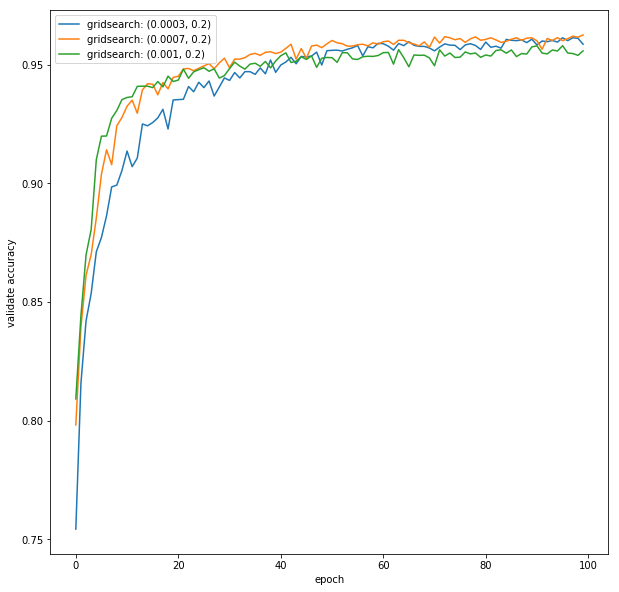

In [69]:
plt.figure(figsize=(10,10))

for j in range(len(load_res)):
    #if(learn_rate[j]>0.001 and learn_rate[j]<0.04):
    plt.plot(load_res[j]['val_acc'],label="gridsearch: "+str(search_grid[j]))
    plt.xlabel("epoch")
    plt.ylabel("validate accuracy")
    
plt.legend()

In [164]:
#get the test accuracy of a selected model
select_model=load_model("../HyperparametersTuning/learn_rate_narrow_AdamM31/model1.h5")

scores=select_model.evaluate(x_test,y_test_origin,verbose=1)

print("%s: %.2f%%" % (select_model.metrics_names[1], scores[1]*100))

10036/10036 [==============================] - 3s 262us/step
acc: 96.04%


## Some other CNN structures we also tested
* a CNN with SGD optimizer,0.2 dropout rate

In [120]:
load_res=gs.load_results(search_grid,"../HyperparametersTuning/0.2dropout_momentum1")

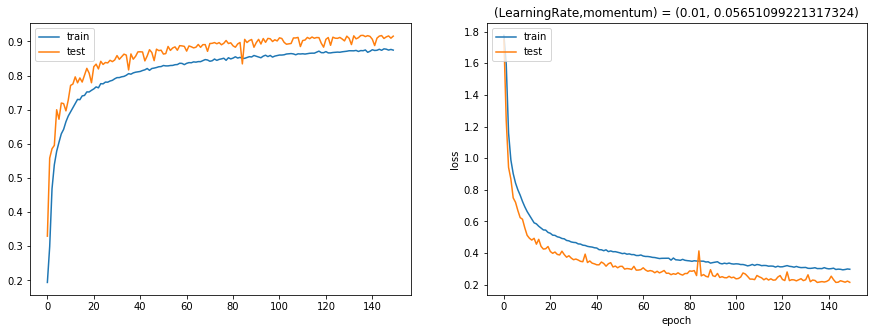

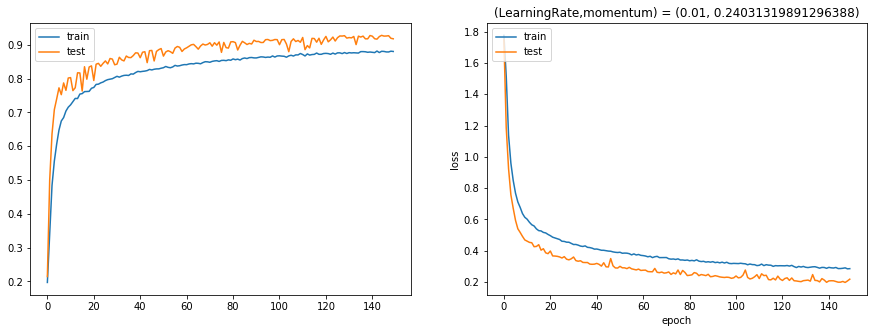

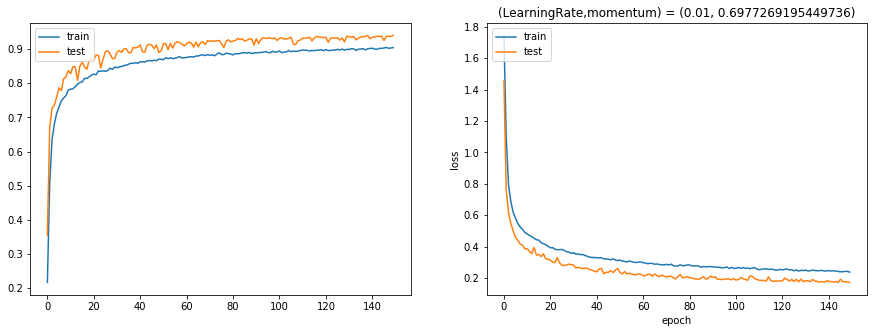

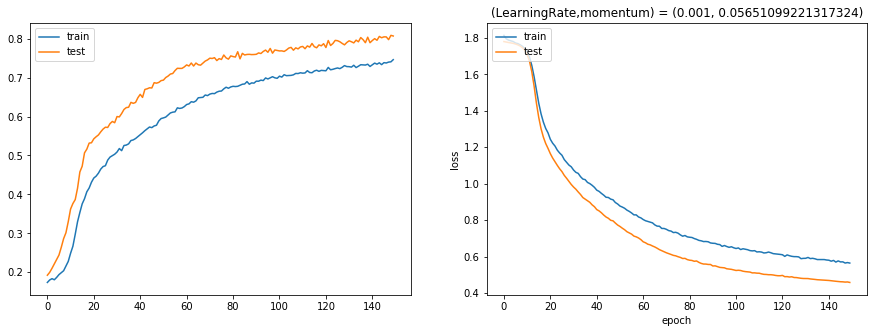

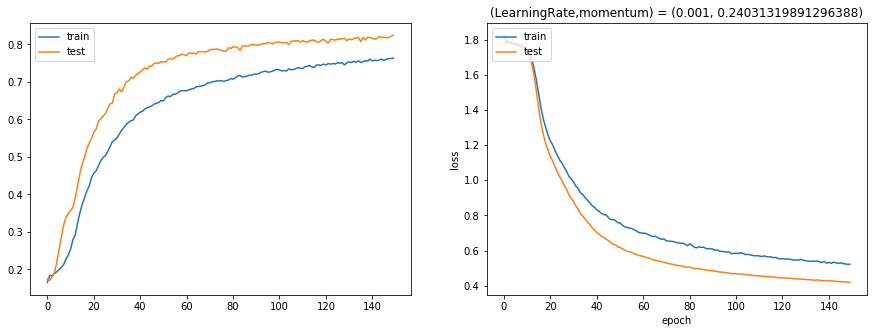

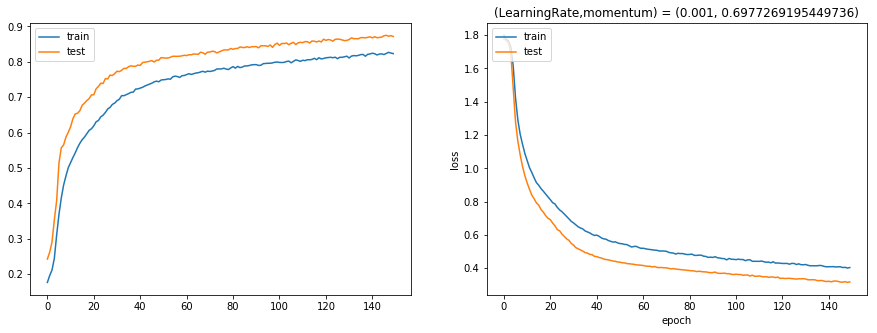

In [121]:
PlotLossAcc(load_res,search_grid)

## Class Activation Map

In [116]:
def visualize_class_activation_map(model_path, img_path):
    #model = load_model(model_path)
    model=model_path
    #original_img = img_to_array(load_img(img_path, grayscale = True))
    original_img=img_path
    width, height, _ = original_img.shape

    #Reshape to the network input shape (3, w, h).
    #img = np.array([np.transpose(np.float32(original_img), (0, 1,2))])
    img = np.array([np.transpose(np.float32(original_img), (0, 1,2))])
        
    #Get the 512 input weights to the softmax.
    class_weights = model.layers[-2].get_weights()[0]
    #final_conv_layer = get_output_layer(model, "conv5_3")
    final_conv_layer = model.layers[14]   #because final convolutional layer is the 14th layer
    get_output = K.function([model.layers[0].input],[final_conv_layer.output, model.layers[-1].output])
    imglist=[]
    imglist.append(img)
    [conv_outputs, predictions] = get_output(imglist)
    conv_outputs = conv_outputs[0, :, :, :]

    #Create the class activation map.
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    target_class = 4
    for i, w in enumerate(class_weights[:,target_class]):
        cam += w * conv_outputs[:, :, i] # i th channel * w_i
    print(predictions)
    cam /= np.max(cam)
    cam = cv2.resize(cam, (height, width))
    #heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap=np.uint8(255*cam)
    heatmap[np.where(cam < 0.9)] = 0
    #original= cv2.applyColorMap(np.uint8(255*(np.max(original_img)-original_img)/(np.max(original_img)-np.min(original_img))), 
                                         #cv2.COLORMAP_BONE)
    original=255*(np.max(original_img)-original_img)/(np.max(original_img)-np.min(original_img))
    
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.reshape(original_img,(64,64)),cmap = 'gray')
    ax1.set_title('Original image')
    #ax2.imshow(heatmap)
    ax2.imshow(heatmap, cmap = 'jet')
    ax2.imshow(np.reshape(original,(64,64)), cmap = 'gray', alpha = 0.5)
    #ax2.set_title('Original image + CAM \n Class: ' + defect_type)

    #print('defect type:', defect_type)
    #img = original_img
    #cv2.imwrite(output_path, img)
    return heatmap

In [88]:
model=load_model("../HyperparametersTuning/learn_rate_narrow_AdamM31/model1.h5")

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_174 (Conv2D)          (None, 60, 60, 8)         200       
_________________________________________________________________
activation_208 (Activation)  (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 56, 56, 16)        3200      
_________________________________________________________________
activation_209 (Activation)  (None, 56, 56, 16)        0         
_________________________________________________________________
max_pooling2d_137 (MaxPoolin (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_171 (Dropout)        (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 24, 24, 32)        12800     
__________

In [151]:
model.layers[4]

In [102]:
img=x_test_origin[1]
imgt = np.array([np.transpose(np.float32(img), (0, 1,2))])

(1, 64, 64, 1)

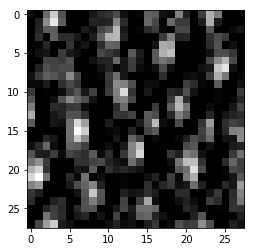

In [159]:
get_output = K.function([model.layers[0].input],[model.layers[4].output])
imglist=[]
imglist.append(imgt)
output=get_output(imglist)
plt.imshow(output[0][0][:,:,15],cmap='gray')

In [153]:
np.shape(output[0][0][:,:,0])

(1, 1, 28, 28, 16)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
  3.9940583e-22]]


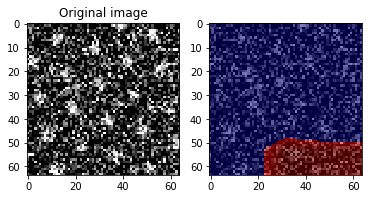

In [117]:
heatmap=visualize_class_activation_map(model, x_test_origin[1])

In [118]:
y_test_origin[1]

array([0., 0., 0., 0., 1., 0.], dtype=float32)

In [99]:
heatmap

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

In [27]:
for i in range(len(model.layers)):
    j=len(model.layers)-i-1
    if "activation_4" in model.layers[j].get_config()['name']:
        final_conv_layer=model.layers[j]
        print(j)
        break
    

10


## Prediction Validation

In [15]:
# load the experimental data
expdata=np.load("defect_list10.npy")

In [153]:
#expdata=expdata.reshape(expdata.shape[0],img_x,img_y,1)

In [16]:
#imgsrc=expdata[0]
imgsrc=x_test[2].reshape(64,64)


# 1/ratio of the radius of the mask to the original image in pixels
maskratio = 10

def FFTmask(imgsrc, maskratio=10):
    """Takes a square real space image and filter out a disk with radius equal to:
    1/maskratio * image size.
    Retruns FFT transform of the image and the filtered FFT transform
    """
    # Take the fourier transform of the image.
    F1 = fftpack.fft2((imgsrc)) 
    # Now shift so that low spatial frequencies are in the center.
    F2 = (fftpack.fftshift((F1)))
    # copy the array and zero out the center
    F3 = F2.copy()
    l = int(imgsrc.shape[0]/maskratio)
    m = int(imgsrc.shape[0]/2)
    y,x = np.ogrid[1: 2*l + 1, 1:2*l + 1]
    mask = (x - l)*(x - l) + (y - l)*(y - l) <= l*l
    F3[m-l:m+l, m-l:m+l] = F3[m-l:m+l, m-l:m+l] * (1 - mask)
    
    return F2, F3

F2, F3 = FFTmask(imgsrc, maskratio)

In [17]:
def FFTsub(imgsrc, F3):
    """Takes real space image and filtred FFT.
    Reconstructs real space image and subtracts it from the original.
    Returns normalized image. 
    """
    reconstruction = np.real(fftpack.ifft2(fftpack.ifftshift(F3)))
    diff = np.abs(imgsrc - reconstruction)
    
    #normalization
    diff = diff - np.amin(diff)
    diff = diff/np.amax(diff)
    
    return diff

In [18]:
diff = FFTsub(imgsrc, F3)
diff.shape

(64, 64)

In [19]:
def threshImg(diff, threshL=0.25, threshH=0.75):
    """Takes in difference image, low and high thresold values, and outputs a map of all defects.
    """
    
    threshIL = diff < threshL  
    threshIH = diff > threshH
    threshI = threshIL + threshIH
    
    return threshI

In [20]:
threshL = 0.25
threshH = 0.75

(-0.5, 63.5, 63.5, -0.5)

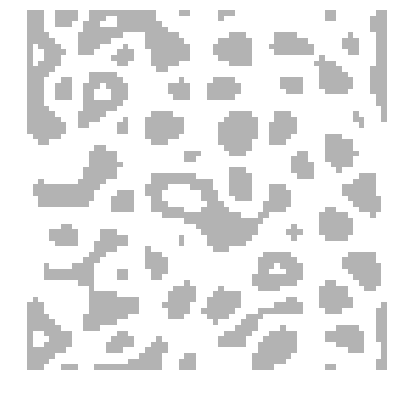

In [24]:
fig104 = plt.figure(104, figsize=(5,5))
ax = fig104.add_axes([0, 0, 1, 1])

threshI = threshImg(diff, threshL, threshH)

#ax.imshow(imgsrc)
#ax.imshow(threshI, cmap='coolwarm', alpha=0.3)
ax.imshow(threshI,cmap="gray", alpha=0.3)
ax.axis('off')